# Programación de Carga de Vehículos Eléctricos: Modelo Exacto vs. Heurística

**Autor:** Javier Esteban Barrera Hernandez
**Curso:** Prescriptive Analytics: Heuristics For Decision-Making
**Actividad:** Proyecto - Fase 1

---

## Introducción

En este cuaderno se desarrolla una solución para la programación de carga de vehículos eléctricos (EV) en estaciones de carga. Se presenta tanto un modelo matemático exacto (MILP) que se resuelve con Gurobi, como una heurística constructiva para abordar el problema. Para cada método se calculan las métricas a nivel global, por vehículo y por cargador, y se generan gráficos de resultados (diagramas de Gantt y gráficos de uso del transformador vs. precio de energía).

La estructura del cuaderno es la siguiente:

1. **Modelo Exacto (MILP):**  
   Se define el modelo matemático, se crean las variables y restricciones, y se resuelve con Gurobi.

2. **Heurística Constructiva:**  
   Se implementa una heurística constructiva para resolver el mismo problema, asignando periodos de carga de forma secuencial según una regla de prioridad.

3. **Cálculo de Métricas y Visualización:**  
   Se extraen las métricas de cada solución (global, por vehículo y por cargador) y se generan gráficos (diagramas de Gantt para cargadores y vehículos; gráfico de uso del transformador vs. precio de energía).

4. **Función Principal y Comparación de Resultados:**  
   Se consolida la ejecución del modelo exacto y la heurística, se comparan las métricas (incluyendo el cálculo del GAP entre ambos) y se guardan los resultados en archivos CSV.



# Sección 1: Modelo Exacto (MILP)

En esta sección se define el modelo matemático para la programación de carga de EV utilizando Gurobi.  
Se leen los datos de la instancia, se generan las variables de decisión (por ejemplo, variables binarias para la asignación de cargadores, energía entregada, tiempos, etc.), se agregan las restricciones del modelo (limitación de cargadores por periodo, restricción de uso del transformador, asignación única por vehículo, etc.) y se define la función objetivo.

El modelo exacto se estructura en la función `build_model(instance)` y se resuelve mediante la función `optimize_instance(model)`.


In [40]:
import gurobipy as gp
from gurobipy import GRB
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import os
import time
import pandas as pd
import seaborn as sns

def read_instance(filename):
    """
    Lee un archivo JSON que contiene la instancia del problema.
    
    Parámetros:
        filename (str): Nombre del archivo que contiene la instancia.
    
    Retorna:
        dict: Instancia del problema en formato diccionario.
    """
    with open(filename, 'r') as f:
        instance = json.load(f)
    return instance

def build_model(instance):
    """
    Define y construye el modelo MILP para la programación de carga de EVs.

    La función extrae los datos básicos de la instancia (precios de energía, tiempos,
    datos de vehículos, parámetros de los cargadores, etc.), define las variables de decisión,
    añade las restricciones según lo planteado (R1 a R12) y establece la función objetivo.

    Parámetros:
        instance (dict): Instancia del problema en formato diccionario.
    
    Retorna:
        model (gurobipy.Model): Modelo MILP construido.
        data (tuple): Datos y conjuntos utilizados en el modelo, para visualización y cálculos posteriores.
    """
    # Se extraen los datos básicos de energía y tiempos
    energy_prices = instance["energy_prices"]
    T = [ep["time"] for ep in energy_prices]
    num_periods = len(T)
    price = { t: energy_prices[t]["price"] for t in range(num_periods) }
    Delta_t = T[1] - T[0] if num_periods >= 2 else 1.0

    # Se extraen los datos de llegada y salida de los vehículos
    arrivals = instance["arrivals"]
    I = [arr["id"] for arr in arrivals]
    arr_time = { arr["id"]: arr["arrival_time"] for arr in arrivals }
    dep_time = { arr["id"]: arr["departure_time"] for arr in arrivals }
    req_energy = { arr["id"]: arr["required_energy"] for arr in arrivals }

    # Se define el conjunto T_i para cada vehículo, que representa los periodos disponibles
    T_i = {}
    for i in I:
        T_i[i] = [t for t in range(num_periods) if T[t] >= arr_time[i] and T[t] <= dep_time[i]]

    # Se extraen los datos de la estación: cargadores y plazas
    chargers = instance["parking_config"]["chargers"]
    C_set = [ch["charger_id"] for ch in chargers]
    P_charger = { ch["charger_id"]: ch["power"] for ch in chargers }
    n_spots = instance["parking_config"]["n_spots"]
    transformer_limit = instance["parking_config"]["transformer_limit"]

    # Se define el tiempo máximo de retraso adicional para cada vehículo (1 hora para todos)
    Delta = { i: 1.0 for i in I }

    # Se calcula un indicador de urgencia U y se define el valor de servicio v
    P_max = max(P_charger[c] for c in C_set)
    U = {}
    for i in I:
        available_time = dep_time[i] + Delta[i] - arr_time[i]
        U[i] = req_energy[i] / available_time if available_time > 0 else 0

    v_base = 100.0
    kappa = 2.0
    v = { i: (kappa * v_base if U[i] > P_max else v_base) for i in I }
    
    # Se definen los costos unitarios: retraso y degradación
    pi_cost = { i: 15.0 for i in I }
    gamma = { i: (0.46 if U[i] > P_max else 0.35) for i in I }
    delta_val = 10.0

    # Se crea el modelo de Gurobi
    model = gp.Model("EV_Charging_Scheduling")
    model.Params.TimeLimit = 3600
    model.Params.MIPGap = 0.01
    model.Params.OutputFlag = 1

    # Se definen las variables de decisión:
    # x[i,t,c]: variable binaria que es 1 si el vehículo i es asignado al cargador c en el periodo t.
    x = {}
    for i in I:
        for t in T_i[i]:
            for c in C_set:
                x[i,t,c] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{t}_{c}")
    
    # z[i,t]: variable binaria que indica si el vehículo i está asignado a algún cargador en el periodo t.
    z = {}
    for i in I:
        for t in T_i[i]:
            z[i,t] = model.addVar(vtype=GRB.BINARY, name=f"z_{i}_{t}")
    
    # E[i]: energía entregada al vehículo i (variable continua, >= 0).
    E = { i: model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"E_{i}") for i in I }
    # F[i]: tiempo de finalización de la carga para el vehículo i.
    F = { i: model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"F_{i}") for i in I }
    # D[i]: retraso (delay) del vehículo i.
    D = { i: model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"D_{i}") for i in I }
    # f_bar: medida de equidad, promedio del nivel de servicio de los vehículos.
    f_bar = model.addVar(vtype=GRB.CONTINUOUS, name="f_bar")
    
    model.update()

    # Restricción (R1): Cada cargador c en cada periodo t puede atender a lo sumo un vehículo.
    for t in range(num_periods):
        for c in C_set:
            model.addConstr(
                gp.quicksum(x[i,t,c] for i in I if t in T_i[i]) <= 1,
                name=f"R1_charger_{c}_time_{t}"
            )
    # Restricción (R2): Cada vehículo i se asigna a lo sumo a un cargador por periodo.
    for i in I:
        for t in T_i[i]:
            model.addConstr(
                gp.quicksum(x[i,t,c] for c in C_set) <= 1,
                name=f"R2_vehicle_{i}_time_{t}"
            )
    # Restricción (R3): La potencia total asignada en cada periodo no excede la capacidad del transformador.
    for t in range(num_periods):
        model.addConstr(
            gp.quicksum(P_charger[c] * x[i,t,c] for i in I if t in T_i[i] for c in C_set)
            <= transformer_limit,
            name=f"R3_transformer_time_{t}"
        )
    # Restricción (R4): El número de vehículos asignados a un periodo no excede el número de plazas.
    for t in range(num_periods):
        model.addConstr(
            gp.quicksum(z[i,t] for i in I if t in T_i[i]) <= n_spots,
            name=f"R4_parking_time_{t}"
        )
    # Restricción (R5): Vinculación entre las variables x e y: z[i,t] es igual a la suma de x[i,t,c].
    for i in I:
        for t in T_i[i]:
            expr = gp.quicksum(x[i,t,c] for c in C_set)
            model.addConstr(z[i,t] <= expr, name=f"R5_link1_{i}_{t}")
            model.addConstr(expr <= z[i,t], name=f"R5_link2_{i}_{t}")
    # Restricción (R6): Se define la energía entregada al vehículo i.
    for i in I:
        model.addConstr(
            E[i] == gp.quicksum(P_charger[c] * Delta_t * x[i,t,c] for t in T_i[i] for c in C_set),
            name=f"R6_energy_{i}"
        )
    # Restricción (R7): La energía entregada no puede exceder la demanda requerida.
    for i in I:
        model.addConstr(E[i] <= req_energy[i], name=f"R7_req_energy_{i}")
    # Restricción (R8): La finalización de carga F[i] se define según el periodo asignado.
    # Se utiliza una constante M grande para condicionar la restricción.
    M_val = T[-1]
    for i in I:
        for t in T_i[i]:
            model.addConstr(
                F[i] >= (T[t] + Delta_t) - M_val * (1 - z[i,t]),
                name=f"R8_finish_{i}_{t}"
            )
    # Restricción (R9): El tiempo de finalización F[i] no excede la salida más una tolerancia.
    for i in I:
        model.addConstr(F[i] <= dep_time[i] + 1, name=f"R9_finish_max_{i}")
    # Restricción (R10): Definición del retraso D[i] como el exceso sobre el tiempo de salida.
    for i in I:
        model.addConstr(D[i] >= F[i] - dep_time[i], name=f"R10_delay_{i}")
    # Restricción (R11): Definición de la medida de equidad f_bar, como el promedio del nivel de servicio.
    model.addConstr(
        f_bar == (1 / len(I)) * gp.quicksum(E[i] / req_energy[i] for i in I),
        name="R11_fair_avg"
    )
    model.update()

    # Se define la función objetivo, maximizando el beneficio neto menos una penalización por inequidad.
    net_benefit = gp.quicksum(
        v[i] * E[i]
        - gp.quicksum(price[t] * P_charger[c] * Delta_t * x[i,t,c] for t in T_i[i] for c in C_set)
        - pi_cost[i] * D[i]
        - gamma[i] * E[i]
        for i in I
    )
    fairness_penalty = gp.quicksum((E[i] / req_energy[i] - f_bar) ** 2 for i in I)
    model.setObjective(net_benefit - delta_val * fairness_penalty, GRB.MAXIMIZE)
    model.update()

    data = (T, price, Delta_t, I, T_i, arr_time, dep_time, req_energy, C_set, P_charger, n_spots, transformer_limit)
    return model, data

def optimize_instance(model):
    """
    Resuelve el modelo MILP utilizando Gurobi.
    
    Retorna:
        model (gurobipy.Model): Modelo resuelto.
    """
    model.optimize()
    return model


# Sección 2: Heurística Constructiva

En esta sección se implementa una heurística constructiva para la programación
de carga. Se calcula un indicador de urgencia basado en el tiempo disponible y
la demanda de cada vehículo y se define una regla de prioridad (combinando \(1/\text{dep\_time}\)
y el indicador de urgencia). Se ordenan los vehículos de mayor a menor prioridad y se recorre la
ventana de cada vehículo para asignar el primer periodo de tiempo (y cargador) disponible
que cumpla con las restricciones de plaza y potencia. Finalmente, se calculan las métricas:
energía entregada, tiempo de finalización y retraso, y se evalúa la función objetivo heurística.


In [41]:
def heuristic_schedule(instance):
    """
    Construye una solución heurística para la programación de carga de EVs de forma constructiva.
    
    La heurística realiza los siguientes pasos:
      1. Extrae los datos de la instancia (precios de energía, tiempos, información de vehículos, 
         cargadores y capacidad del transformador).
      2. Define la ventana de tiempo disponible para cada vehículo (T_i).
      3. Calcula un indicador de urgencia U para cada vehículo basado en su tiempo disponible y demanda requerida.
      4. Define una regla de prioridad combinando el inverso del tiempo de salida con el indicador de urgencia.
      5. Ordena los vehículos de mayor a menor prioridad.
      6. Recorre la ventana de cada vehículo y asigna el primer período disponible que cumpla las restricciones de plazas,
         límite del transformador y disponibilidad de cargadores.
      7. Calcula las métricas (energía entregada, tiempo de finalización, retraso, nivel de servicio, utilización de cargadores y uso del transformador).
      8. Calcula la función objetivo heurística, usando un beneficio neto derivado de los parámetros de valor de servicio,
         costo unitario de retraso y degradación, y penaliza la inequidad en el nivel de servicio.
    
    Parámetros:
        instance (dict): Instancia del problema en formato diccionario.
    
    Retorna:
        dict: Una solución heurística que incluye la asignación, programación por vehículo,
              energía entregada, tiempos de finalización, retrasos y las métricas asociadas.
    """
    # Se extraen los datos básicos de la instancia (precios, tiempos, etc.)
    energy_prices = instance["energy_prices"]
    T = [ep["time"] for ep in energy_prices]
    num_periods = len(T)
    price = {t: energy_prices[t]["price"] for t in range(num_periods)}
    Delta_t = T[1] - T[0] if num_periods >= 2 else 1.0

    arrivals = instance["arrivals"]
    I = [arr["id"] for arr in arrivals]
    arr_time = {arr["id"]: arr["arrival_time"] for arr in arrivals}
    dep_time = {arr["id"]: arr["departure_time"] for arr in arrivals}
    req_energy = {arr["id"]: arr["required_energy"] for arr in arrivals}
    
    # Se define el conjunto T_i para cada vehículo (períodos dentro de su ventana)
    T_i = {i: [t for t in range(num_periods) if T[t] >= arr_time[i] and T[t] <= dep_time[i]] for i in I}
    
    # Se extraen los datos de cargadores y parámetros de la estación
    chargers = instance["parking_config"]["chargers"]
    C_set = [ch["charger_id"] for ch in chargers]
    P_charger = {ch["charger_id"]: ch["power"] for ch in chargers}
    n_spots = instance["parking_config"]["n_spots"]
    transformer_limit = instance["parking_config"]["transformer_limit"]
    
    # Se define el tiempo máximo de retraso adicional para cada vehículo (1 hora para todos)
    Delta = {i: 1.0 for i in I}
    
    # Se calcula el indicador de urgencia U para cada vehículo
    # U[i] = (demanda requerida) / (tiempo disponible)
    P_max = max(P_charger[c] for c in C_set)
    U = {}
    for i in I:
        available_time = dep_time[i] + Delta[i] - arr_time[i]
        U[i] = req_energy[i] / available_time if available_time > 0 else 0

    # Se definen los parámetros de valoración y costos, de forma similar al modelo MILP:
    # Valor de servicio: se asigna un valor base y se multiplica por un factor de urgencia.
    v_base = 100.0
    kappa = 2.0
    v = {i: (kappa * v_base if U[i] > P_max else v_base) for i in I}
    # Costo unitario de retraso
    pi_cost = {i: 15.0 for i in I}
    # Costo de degradación (lineal) de la batería, depende del indicador U
    gamma = {i: (0.46 if U[i] > P_max else 0.35) for i in I}
    # Coeficiente de penalización por inequidad (fairness)
    delta_val = 10.0

    # Se definen estructuras para llevar el registro de la asignación
    parking_usage = {t: 0 for t in range(num_periods)}
    transformer_usage = {t: 0.0 for t in range(num_periods)}
    charger_available = {c: {t: 1 for t in range(num_periods)} for c in C_set}
    
    # Se inicializan estructuras para almacenar la asignación y la programación por vehículo:
    # assignment: diccionario para almacenar asignaciones del tipo (vehículo, tiempo, cargador)
    # vehicle_schedule: para cada vehículo, lista de tuplas (tiempo asignado, cargador)
    assignment = {}
    vehicle_schedule = {i: [] for i in I}
    # E: energía entregada por vehículo, F: tiempo de finalización, D: retraso
    E = {i: 0.0 for i in I}
    F = {i: None for i in I}
    D = {i: 0.0 for i in I}

    # Se ordenan los vehículos de forma descendente de prioridad
    # La prioridad se define como la suma del inverso del tiempo de salida y el indicador U.
    priority = {i: 1.0 / dep_time[i] + U[i] for i in I}
    sorted_I = sorted(I, key=lambda i: priority[i], reverse=True)

    # Se recorre cada vehículo, en orden de prioridad, para asignar periodos de carga
    for i in sorted_I:
        energy_i = 0.0
        start_assigned = None
        last_assigned = None
        # Se recorre la ventana temporal disponible para el vehículo
        for t in T_i[i]:
            # Se verifica que exista plaza en el estacionamiento en el periodo t
            if parking_usage[t] >= n_spots:
                continue
            # Se verifica el límite del transformador en el periodo t
            if transformer_usage[t] >= transformer_limit:
                continue
            assigned = False
            # Se revisa cada cargador: se asigna el primero disponible que no exceda el límite del transformador.
            for c in C_set:
                if charger_available[c][t] == 1:
                    if transformer_usage[t] + P_charger[c] > transformer_limit:
                        continue
                    # Se asigna el vehículo i al cargador c en el periodo t
                    assignment[(i, t, c)] = 1
                    vehicle_schedule[i].append((t, c))
                    # Se marca el cargador como ocupado en el periodo t
                    charger_available[c][t] = 0
                    parking_usage[t] += 1
                    transformer_usage[t] += P_charger[c]
                    energy_i += P_charger[c] * Delta_t
                    if start_assigned is None:
                        start_assigned = t
                    last_assigned = t
                    assigned = True
                    break  # Se asigna el primer cargador disponible que cumpla las restricciones.
            if assigned and energy_i >= req_energy[i]:
                break  # Se finaliza la asignación para el vehículo si se satisface la demanda.
        E[i] = min(energy_i, req_energy[i])
        if last_assigned is not None:
            F[i] = T[last_assigned] + Delta_t  # Se define el tiempo de finalización
        else:
            F[i] = arr_time[i]
        D[i] = max(0.0, F[i] - dep_time[i])  # Se calcula el retraso (si existe)

    # Se calcula el nivel de servicio de cada vehículo y la medida de equidad f_bar
    service_levels = {i: E[i] / req_energy[i] if req_energy[i] > 0 else 0 for i in I}
    f_bar_val = np.mean(list(service_levels.values()))
    fairness_penalty = sum((service_levels[i] - f_bar_val) ** 2 for i in I)

    # Se calcula el costo de energía en función de la asignación realizada
    energy_cost = 0.0
    for (i, t, c), val in assignment.items():
        if val == 1:
            energy_cost += price[t] * P_charger[c] * Delta_t

    # Se calcula el beneficio neto (total_benefit) de forma similar al modelo exacto:
    # Se suma el beneficio por energía entregada y se resta el costo por retrasos y degradación.
    total_benefit = sum(v[i] * E[i] - pi_cost[i] * D[i] - gamma[i] * E[i] for i in I)
    heuristic_obj = total_benefit - energy_cost - delta_val * fairness_penalty

    # Cálculo de métricas globales
    avg_energy = np.mean([E[i] for i in I])
    avg_service = np.mean([service_levels[i] for i in I])
    avg_delay = np.mean([D[i] for i in I])
    charger_active = {c: 0 for c in C_set}
    for t in range(num_periods):
        for c in C_set:
            for i in I:
                if t in T_i[i] and (i, t, c) in assignment:
                    charger_active[c] += 1
                    break
    charger_util = {c: charger_active[c] / num_periods * 100 for c in C_set}
    avg_charger_util = np.mean(list(charger_util.values()))
    transformer_utilization = np.mean(list(transformer_usage.values()))
    
    heuristic_metrics = {
        "objective_value": heuristic_obj,
        "avg_energy_delivered_kWh": avg_energy,
        "avg_service_level": avg_service,
        "avg_delay_hours": avg_delay,
        "avg_charger_utilization_percent": avg_charger_util,
        "transformer_utilization_kW": transformer_utilization
    }

    sol = {
        "assignment": assignment,
        "vehicle_schedule": vehicle_schedule,
        "E": E,
        "F": F,
        "D": D,
        "heuristic_metrics": heuristic_metrics,
        "service_levels": service_levels,
        "fairness_penalty": fairness_penalty
    }
    return sol


# Sección 3: Cálculo de Métricas y Visualización

En esta sección se definen funciones para extraer las métricas globales, a nivel de vehículo y
de cargador, tanto para el modelo exacto (MILP) como para la solución heurística. Además, se incluyen
funciones de visualización para generar:
- Diagramas de Gantt a nivel de cargadores.
- Diagramas de Gantt a nivel de vehículos.
- Gráfico del uso del transformador versus el precio de la energía.

Estas funciones permiten comparar visualmente ambos métodos para una instancia seleccionada.


In [42]:
def extract_metrics(model, data):
    """
    Extrae y calcula las métricas del modelo MILP resuelto.

    Parámetros:
        model (gurobipy.Model): El modelo MILP resuelto.
        data (tuple): Conjuntos de datos y parámetros utilizados en el modelo.

    Retorna:
        dict: Métricas globales (valor objetivo, tiempo de ejecución, gap, energía promedio entregada, 
              nivel de servicio, demora promedio, utilización de cargadores y uso promedio del transformador).
    """
    T, price, Delta_t, I, T_i, arr_time, dep_time, req_energy, C_set, P_charger, n_spots, transformer_limit = data
    obj_value = model.ObjVal
    runtime = model.Runtime
    mip_gap = 0.0
    if abs(model.ObjVal) > 1e-6 and model.ObjBound > -GRB.INFINITY:
        mip_gap = abs(model.ObjVal - model.ObjBound) / abs(model.ObjVal) * 100

    energy_delivered = {}
    delays = {}
    service_levels = {}
    # Se recorre cada vehículo para obtener energía entregada, retraso y nivel de servicio
    for i in I:
        E_val = model.getVarByName(f"E_{i}").X
        D_val = model.getVarByName(f"D_{i}").X
        energy_delivered[i] = E_val
        delays[i] = D_val
        service_levels[i] = E_val / req_energy[i] if req_energy[i] > 0 else 0

    avg_energy = np.mean(list(energy_delivered.values()))
    avg_service = np.mean(list(service_levels.values()))
    avg_delay = np.mean(list(delays.values()))

    total_slots = len(T)
    charger_active = { c: 0 for c in C_set }
    # Se determina la cantidad de períodos que cada cargador fue utilizado
    for t in range(total_slots):
        for c in C_set:
            for i in I:
                if t in T_i[i] and model.getVarByName(f"x_{i}_{t}_{c}").X > 0.5:
                    charger_active[c] += 1
                    break
    charger_util = { c: charger_active[c] / total_slots * 100 for c in C_set }
    avg_cu = np.mean(list(charger_util.values()))
    
    transformer_utilization = np.mean([
        sum(P_charger[c] * model.getVarByName(f"x_{i}_{t}_{c}").X for i in I if t in T_i[i] for c in C_set)
        for t in range(total_slots)
    ])
    
    metrics = {
        "objective_value": obj_value,
        "gurobi_runtime_sec": runtime,
        "mip_gap_percent": mip_gap,
        "avg_energy_delivered_kWh": avg_energy,
        "avg_service_level": avg_service,
        "avg_delay_hours": avg_delay,
        "avg_charger_utilization_percent": avg_cu,
        "transformer_utilization_kW": transformer_utilization
    }
    return metrics

def plot_gantt_chart(model, data):
    """
    Genera un diagrama de Gantt a nivel de cargadores para la solución obtenida mediante el modelo MILP.

    Parámetros:
        model (gurobipy.Model): El modelo MILP resuelto.
        data (tuple): Conjuntos de datos, entre los cuales se incluyen los tiempos T, 
                      conjunto de cargadores, etc.
    """
    T, price, Delta_t, I, T_i, _, _, _, C_set, P_charger, _, _ = data
    fig, ax = plt.subplots(figsize=(12,6))
    cmap = plt.cm.get_cmap('tab20', len(I))
    # Se recorre cada cargador y se agrupan las asignaciones consecutivas en el tiempo
    for c in C_set:
        intervals = []
        for t in range(len(T)):
            veh = None
            for i in I:
                if t in T_i[i]:
                    try:
                        if model.getVarByName(f"x_{i}_{t}_{c}").X > 0.5:
                            veh = i
                            break
                    except:
                        pass
            if veh is not None:
                intervals.append((t, veh))
        grouped = []
        if intervals:
            start_idx, veh_id = intervals[0]
            start_time = T[start_idx]
            end_time = T[start_idx] + Delta_t
            for (idx, veh_new) in intervals[1:]:
                if veh_new == veh_id and np.isclose(T[idx], end_time):
                    end_time += Delta_t
                else:
                    grouped.append((veh_id, start_time, end_time))
                    start_idx, veh_id = idx, veh_new
                    start_time = T[idx]
                    end_time = T[idx] + Delta_t
            grouped.append((veh_id, start_time, end_time))
        y_label = f"Cargador {c}"
        for (veh_id, s, e) in grouped:
            ax.barh(y_label, e-s, left=s, height=0.4, color=cmap(int(veh_id)), edgecolor='black')
            ax.text(s + (e-s)/2, y_label, f"{veh_id}", ha='center', va='center', fontsize=8, color='white')
    ax.set_xlabel("Tiempo (horas)")
    ax.set_title("Diagrama de Gantt (Modelo MILP): Uso de Cargadores")
    plt.tight_layout()
    plt.show()

def plot_transformer_usage_price(model, data):
    """
    Genera un gráfico que muestra el uso del transformador en kW versus el precio de energía
    ($/kWh), para la solución obtenida mediante el modelo MILP.

    Parámetros:
        model (gurobipy.Model): El modelo MILP resuelto.
        data (tuple): Conjuntos de datos (tiempos, precios, cargadores, etc.).
    """
    T, price, Delta_t, I, T_i, _, _, _, C_set, P_charger, _, transformer_limit = data
    transf_usage = []
    prices = []
    for t in range(len(T)):
        usage = 0.0
        for i in I:
            if t in T_i[i]:
                for c in C_set:
                    if model.getVarByName(f"x_{i}_{t}_{c}").X > 0.5:
                        usage += P_charger[c]
        transf_usage.append(usage)
        prices.append(price[t])
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.plot(T, transf_usage, 'b-', label='Uso del Transformador (kW)')
    ax1.axhline(transformer_limit, color='gray', linestyle='--', label='Capacidad Transformador')
    ax1.set_xlabel("Tiempo (horas)")
    ax1.set_ylabel("Uso del Transformador (kW)", color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_title("Uso del Transformador y Precio de Energía (Modelo MILP)")

    ax2 = ax1.twinx()
    ax2.plot(T, [price[t] for t in range(len(T))], 'r--', label='Precio de Energía ($/kWh)')
    ax2.set_ylabel("Precio de Energía ($/kWh)", color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.tight_layout()
    plt.show()

def plot_vehicle_activity_gantt(model, data):
    """
    Genera un diagrama de Gantt a nivel de vehículos para la solución obtenida mediante el modelo MILP.

    Parámetros:
        model (gurobipy.Model): El modelo MILP resuelto.
        data (tuple): Conjuntos de datos (tiempos, ventanas por vehículo, llegadas, salidas, etc.).
    """
    T, price, Delta_t, I, T_i, arr_time, dep_time, req_energy, C_set, P_charger, _, _ = data
    fig, ax = plt.subplots(figsize=(12, 0.5*len(I)+4))
    cmap = plt.cm.get_cmap('Set2', len(C_set))
    for idx, i in enumerate(I):
        y = idx
        arrival = arr_time[i]
        departure = dep_time[i]
        # Se dibuja una línea que representa el periodo de disponibilidad del vehículo
        ax.hlines(y=y, xmin=arrival, xmax=departure, color='lightgray', linewidth=10, alpha=0.5)
        ax.plot(arrival, y, marker="|", color="black", markersize=12)
        ax.plot(departure, y, marker="|", color="black", markersize=12)
        # Se recorre la ventana de tiempo para marcar los periodos asignados
        for t in T_i[i]:
            left = T[t]
            width = Delta_t
            assigned = False
            charg = None
            for c in C_set:
                try:
                    if model.getVarByName(f"x_{i}_{t}_{c}").X > 0.5:
                        assigned = True
                        charg = c
                        break
                except:
                    pass
            if assigned:
                ax.add_patch(plt.Rectangle((left, y-0.4), width, 0.8, color=cmap(charg), alpha=0.9))
                ax.text(left+width/2, y, f"{charg}", ha="center", va="center", fontsize=8, color="white")
            else:
                ax.add_patch(plt.Rectangle((left, y-0.4), width, 0.8, color="red", alpha=0.5))
                ax.text(left+width/2, y, "-", ha="center", va="center", fontsize=8, color="white")
    ax.set_yticks(range(len(I)))
    ax.set_yticklabels([f"Vehículo {i}" for i in I])
    ax.set_xlabel("Tiempo (horas)")
    ax.set_title("Diagrama de Gantt (Modelo MILP): Actividad de Vehículos")
    plt.tight_layout()
    plt.show()

# Funciones de visualización para la solución heurística

def plot_heuristic_gantt_chargers(sol, T, Delta_t, C_set, P_charger):
    """
    Genera un diagrama de Gantt a nivel de cargadores para la solución heurística.
    
    Parámetros:
        sol (dict): Solución obtenida por la heurística, que incluye la programación por vehículo.
        T (list): Lista de tiempos.
        Delta_t (float): Intervalo de tiempo por periodo.
        C_set (list): Conjunto de identificadores de cargadores.
        P_charger (dict): Potencias de cada cargador.
    """
    fig, ax = plt.subplots(figsize=(12,6))
    cmap = plt.cm.get_cmap('tab20', len(sol["vehicle_schedule"]))
    for c in C_set:
        intervals = []
        for t in range(len(T)):
            veh = None
            for i, sched in sol["vehicle_schedule"].items():
                for (t_assigned, c_assigned) in sched:
                    if t_assigned == t and c_assigned == c:
                        veh = i
                        break
                if veh is not None:
                    break
            if veh is not None:
                intervals.append((t, veh))
        grouped = []
        if intervals:
            start_idx, veh_id = intervals[0]
            start_time = T[start_idx]
            end_time = T[start_idx] + Delta_t
            for (idx, veh_new) in intervals[1:]:
                if veh_new == veh_id and np.isclose(T[idx], end_time):
                    end_time += Delta_t
                else:
                    grouped.append((veh_id, start_time, end_time))
                    start_idx, veh_id = idx, veh_new
                    start_time = T[idx]
                    end_time = T[idx] + Delta_t
            grouped.append((veh_id, start_time, end_time))
        y_label = f"Cargador {c}"
        for (veh_id, s, e) in grouped:
            ax.barh(y_label, e-s, left=s, height=0.4, color=cmap(int(veh_id)), edgecolor='black')
            ax.text(s + (e-s)/2, y_label, f"{veh_id}", ha='center', va='center', fontsize=8, color='white')
    ax.set_xlabel("Tiempo (horas)")
    ax.set_title("Diagrama de Gantt (Heurística): Uso de Cargadores")
    plt.tight_layout()
    plt.show()

def plot_heuristic_transformer_usage(sol, T, price, Delta_t, I, T_i, P_charger, C_set, transformer_limit):
    """
    Genera un gráfico de uso del transformador versus precio de energía basado en la solución heurística.

    Parámetros:
        sol (dict): Solución heurística que contiene la programación de vehículos.
        T (list): Lista de tiempos.
        price (dict): Precios de energía por periodo.
        Delta_t (float): Intervalo de tiempo.
        I (list): Lista de identificadores de vehículos.
        T_i (dict): Ventanas temporales disponibles para cada vehículo.
        P_charger (dict): Potencia asociada a cada cargador.
        C_set (list): Conjunto de cargadores.
        transformer_limit (float): Límite de potencia del transformador.
    """
    total_slots = len(T)
    transformer_usage = [0.0] * total_slots
    for t in range(total_slots):
        usage = 0.0
        for i in I:
            if t in T_i[i]:
                for (t_assigned, c_assigned) in sol["vehicle_schedule"][i]:
                    if t_assigned == t:
                        usage += P_charger[c_assigned]
                        break
        transformer_usage[t] = usage
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.plot(T, transformer_usage, 'b-', label='Uso del Transformador (kW)')
    ax1.axhline(transformer_limit, color='gray', linestyle='--', label='Capacidad Transformador')
    ax1.set_xlabel("Tiempo (horas)")
    ax1.set_ylabel("Uso del Transformador (kW)", color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_title("Uso del Transformador y Precio de Energía (Heurística)")

    ax2 = ax1.twinx()
    ax2.plot(T, [price[t] for t in range(len(T))], 'r--', label='Precio de Energía ($/kWh)')
    ax2.set_ylabel("Precio de Energía ($/kWh)", color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.tight_layout()
    plt.show()

def plot_heuristic_vehicle_activity(sol, T, Delta_t, I, T_i, arr_time, dep_time, C_set):
    """
    Genera un diagrama de Gantt a nivel de vehículos basado en la solución heurística.

    Parámetros:
        sol (dict): Solución heurística que contiene los horarios asignados a cada vehículo.
        T (list): Lista de tiempos.
        Delta_t (float): Duración de cada intervalo de tiempo.
        I (list): Lista de identificadores de vehículos.
        T_i (dict): Ventanas temporales disponibles para cada vehículo.
        arr_time (dict): Tiempo de llegada para cada vehículo.
        dep_time (dict): Tiempo de salida para cada vehículo.
        C_set (list): Conjunto de identificadores de cargadores.
    """
    fig, ax = plt.subplots(figsize=(12, 0.5*len(I)+4))
    cmap = plt.cm.get_cmap('Set2', len(C_set))
    for idx, i in enumerate(I):
        y = idx
        arrival = arr_time[i]
        departure = dep_time[i]
        # Se representa la actividad del vehículo a lo largo de su ventana de tiempo
        ax.hlines(y=y, xmin=arrival, xmax=departure, color='lightgray', linewidth=10, alpha=0.5)
        ax.plot(arrival, y, marker="|", color="black", markersize=12)
        ax.plot(departure, y, marker="|", color="black", markersize=12)
        for t in T_i[i]:
            left = T[t]
            width = Delta_t
            assigned = False
            charg_assigned = None
            # Se verifica si en el periodo t el vehículo tiene una asignación de cargador
            for (t_assigned, c_assigned) in sol["vehicle_schedule"][i]:
                if t_assigned == t:
                    assigned = True
                    charg_assigned = c_assigned
                    break
            if assigned:
                ax.add_patch(plt.Rectangle((left, y-0.4), width, 0.8, color=cmap(charg_assigned), alpha=0.9))
                ax.text(left+width/2, y, f"{charg_assigned}", ha="center", va="center", fontsize=8, color="white")
            else:
                ax.add_patch(plt.Rectangle((left, y-0.4), width, 0.8, color="red", alpha=0.5))
                ax.text(left+width/2, y, "-", ha="center", va="center", fontsize=8, color="white")
    ax.set_yticks(range(len(I)))
    ax.set_yticklabels([f"Vehículo {i}" for i in I])
    ax.set_xlabel("Tiempo (horas)")
    ax.set_title("Diagrama de Gantt (Heurística): Actividad de Vehículos")
    plt.tight_layout()
    plt.show()


# Sección 4: Función Principal

En esta sección se consolida la ejecución del modelo exacto y de la heurística.  
Se resuelven las instancias definidas, se extraen las métricas globales, por vehículo y por cargador,
y se calcula el GAP entre ambos métodos. Además, para la instancia seleccionada (por ejemplo, "test_system_1.json")
se generan los gráficos (diagramas de Gantt y gráfico de uso del transformador vs. precio de la energía) para ambas
soluciones. Finalmente, los resultados se guardan en archivos CSV para su posterior análisis.


Procesando instancia test_system_1.json...
Set parameter TimeLimit to value 3600
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2125 rows, 2503 columns and 14228 nonzeros
Model fingerprint: 0x8bf4522d
Model has 65 quadratic objective terms
Variable types: 97 continuous, 2406 integer (2406 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+01]
  Objective range  [2e+01, 2e+02]
  QObjective range [2e-02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 4e+01]
Found heuristic solution: objective -9.60000e+11
Presolve removed 1427 rows and 469 columns
Presolve time: 0.01s
Presolved: 698 rows, 2034 columns, 6066 nonzeros
Presolved model has 65 quadratic objective terms
Found heuristic solution: objective -0.000

C:\Users\57313\AppData\Local\Temp\ipykernel_19660\371536715.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(I))


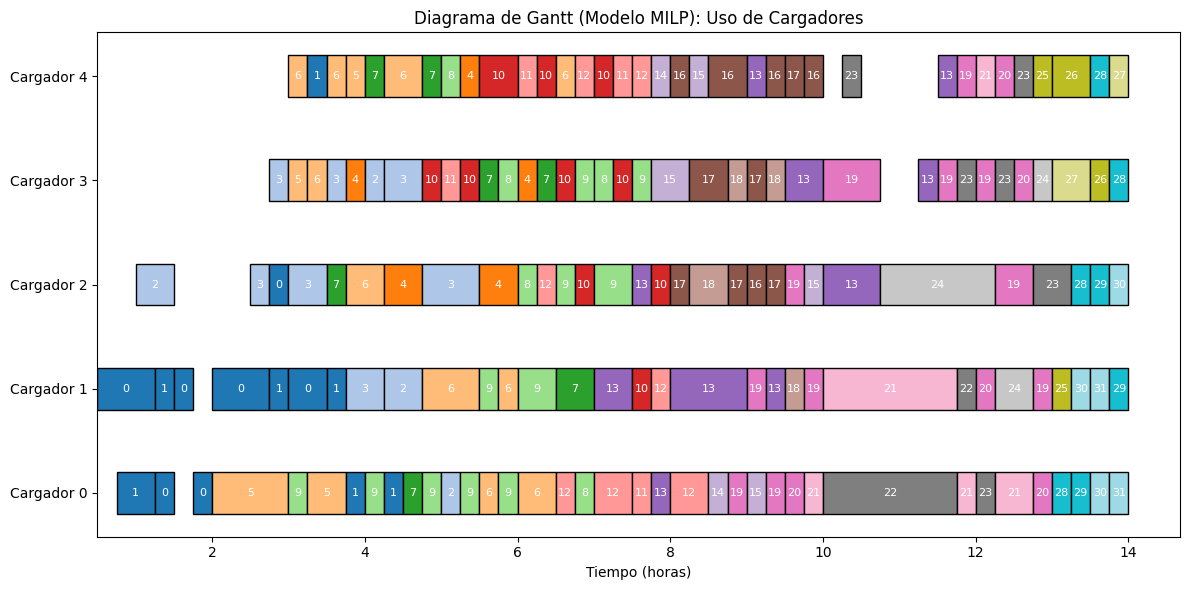

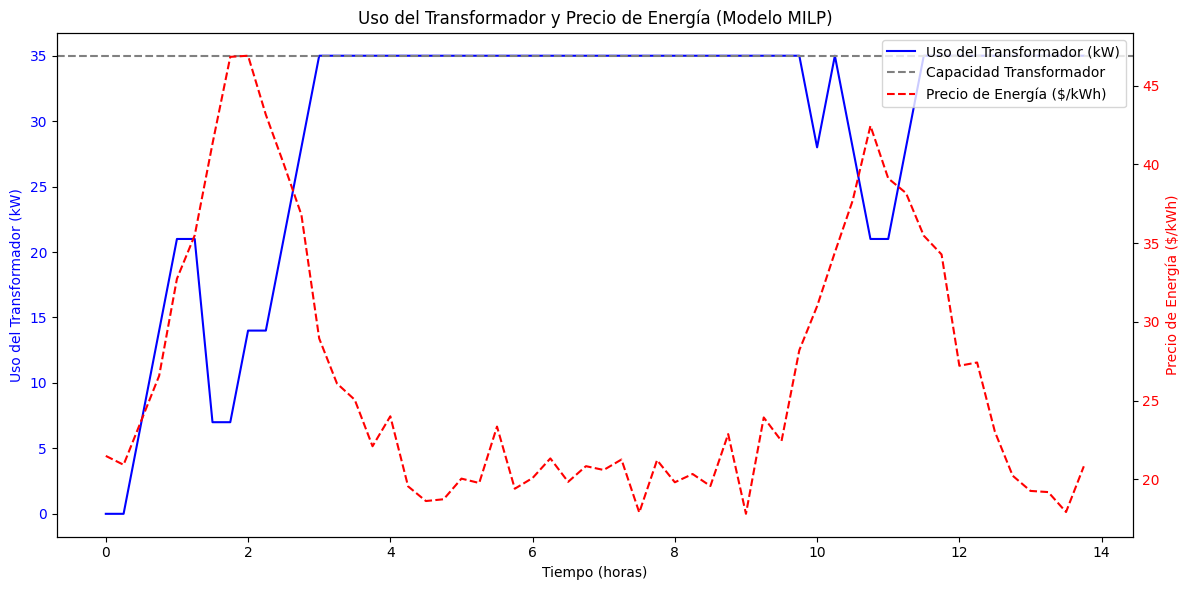

C:\Users\57313\AppData\Local\Temp\ipykernel_19660\371536715.py:164: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set2', len(C_set))


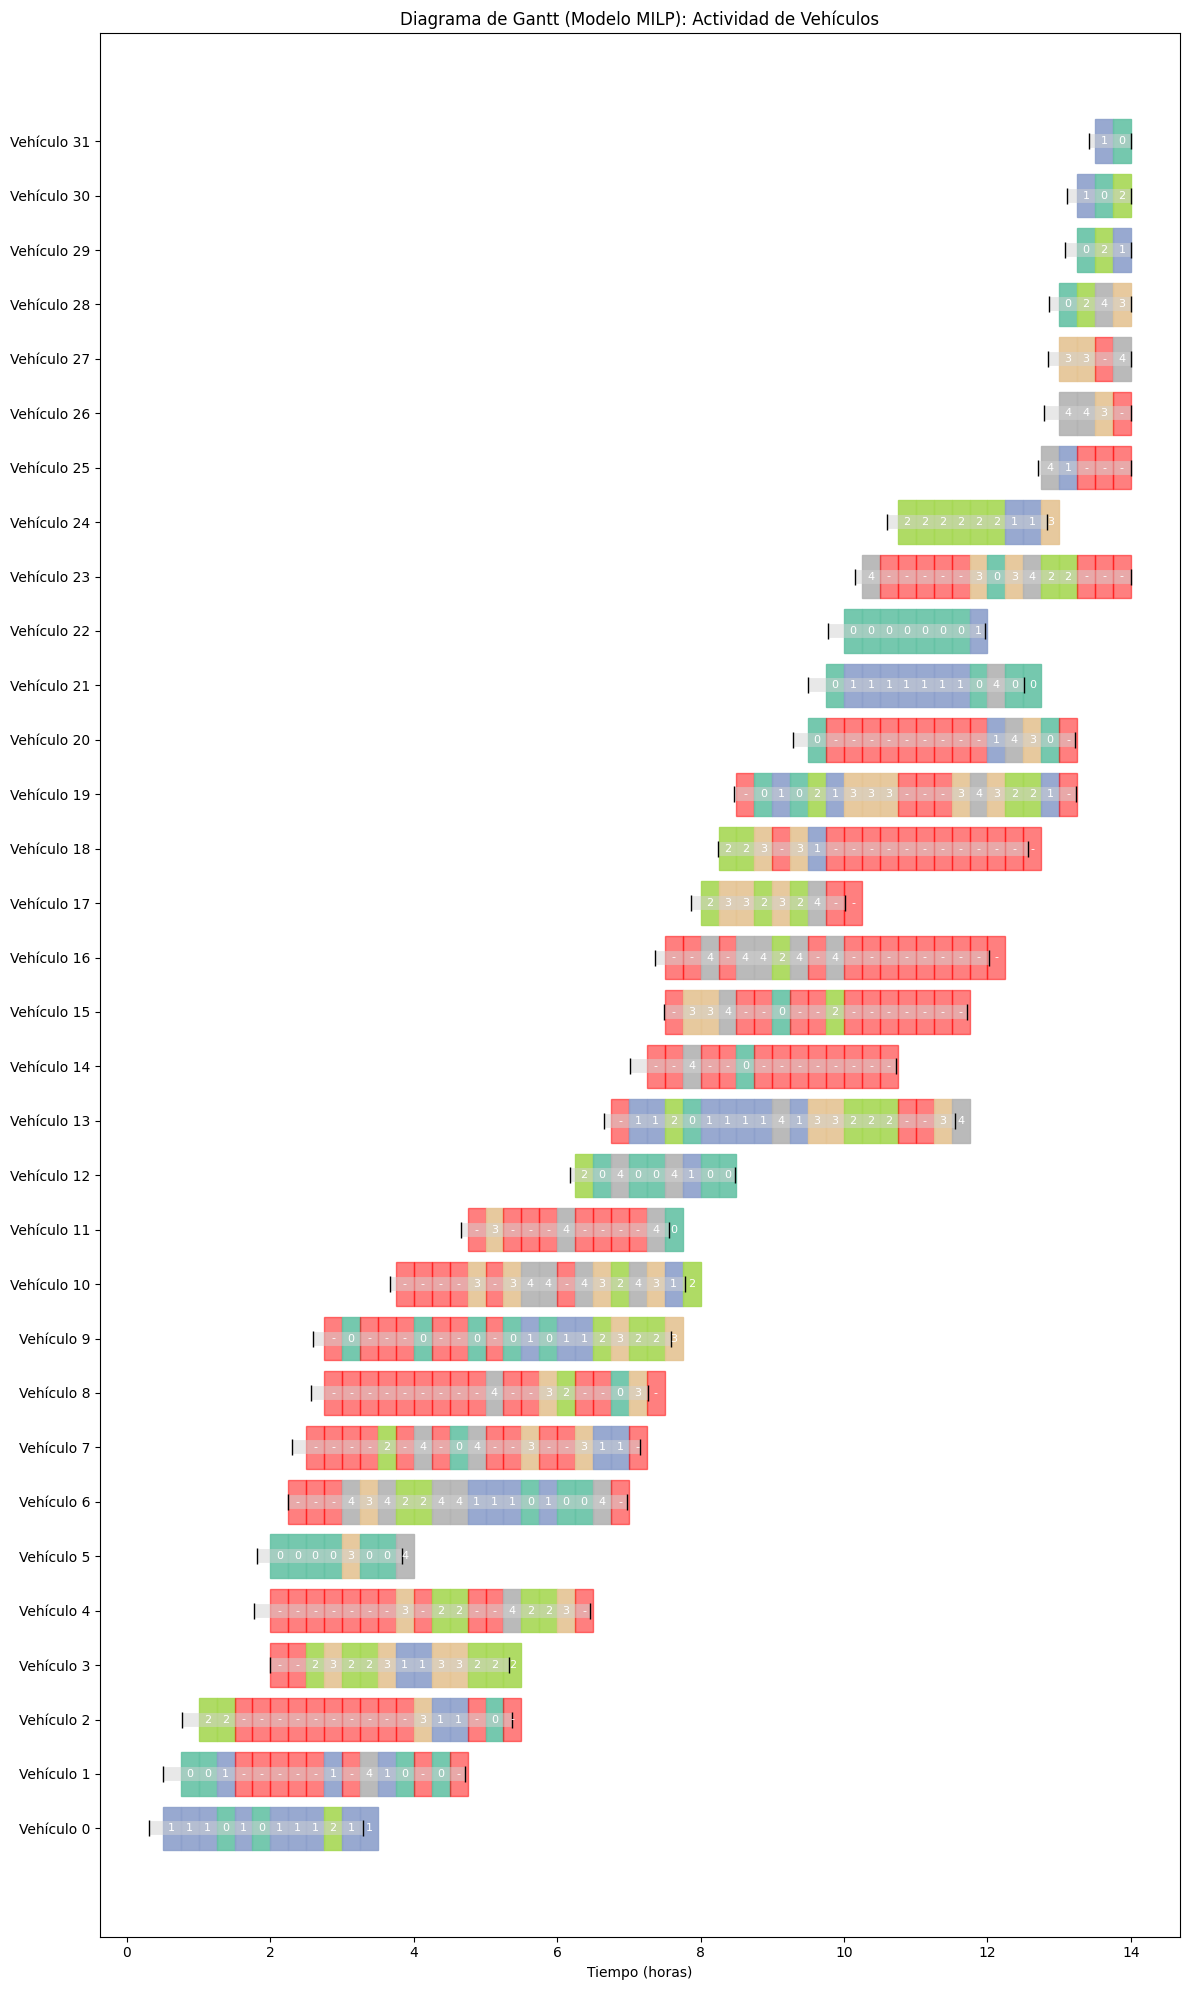

Generando gráficos para test_system_1.json (Heurística)...


C:\Users\57313\AppData\Local\Temp\ipykernel_19660\371536715.py:214: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(sol["vehicle_schedule"]))


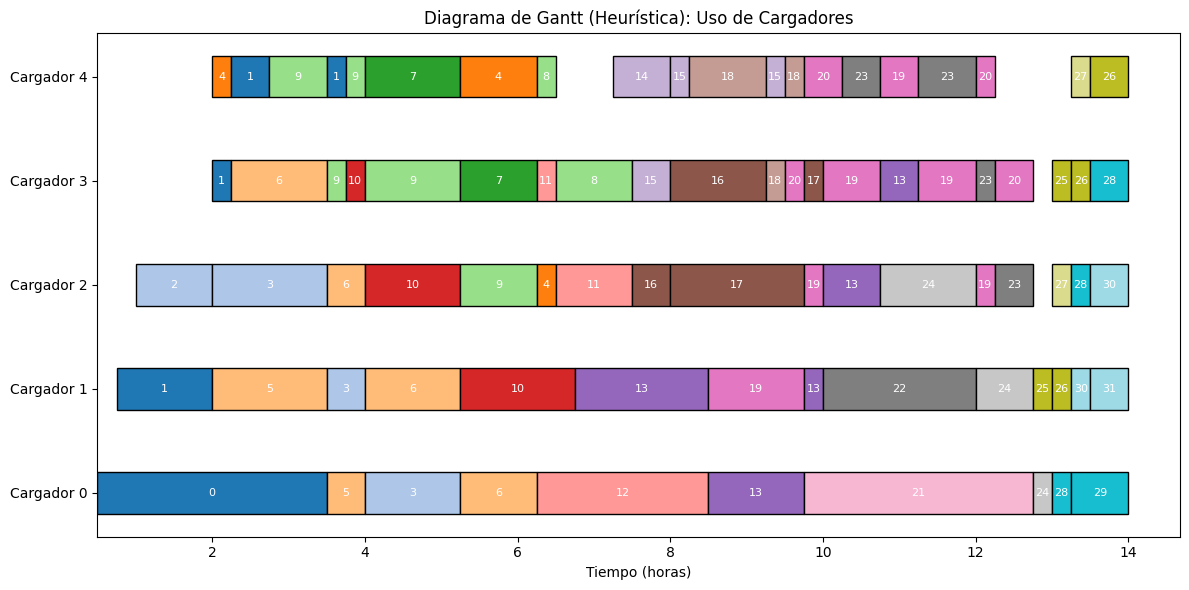

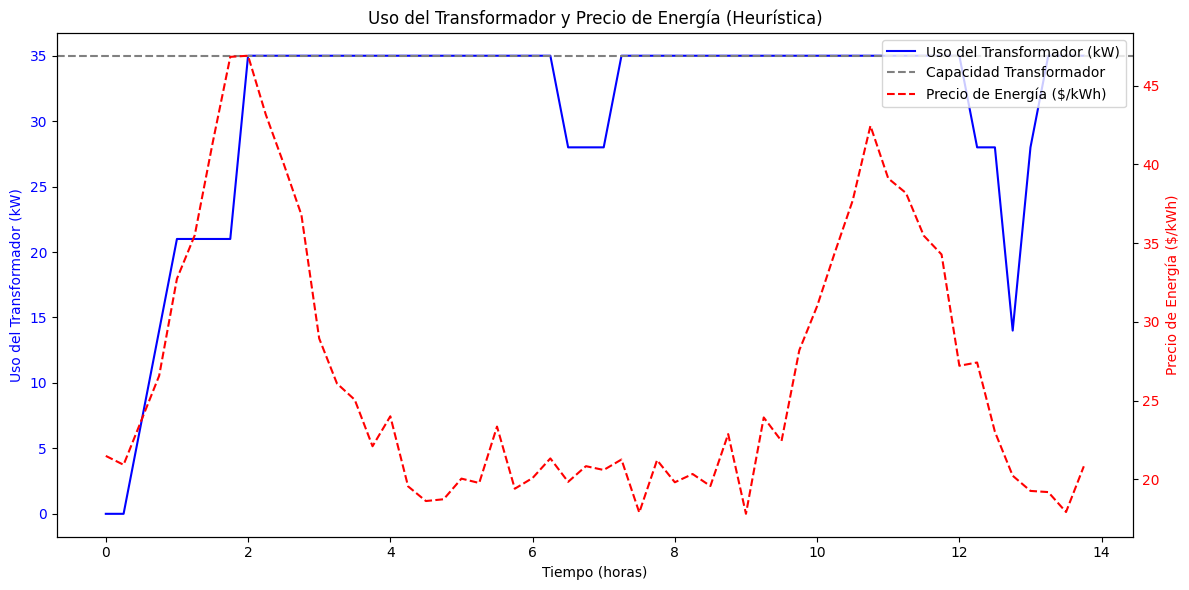

C:\Users\57313\AppData\Local\Temp\ipykernel_19660\371536715.py:311: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set2', len(C_set))


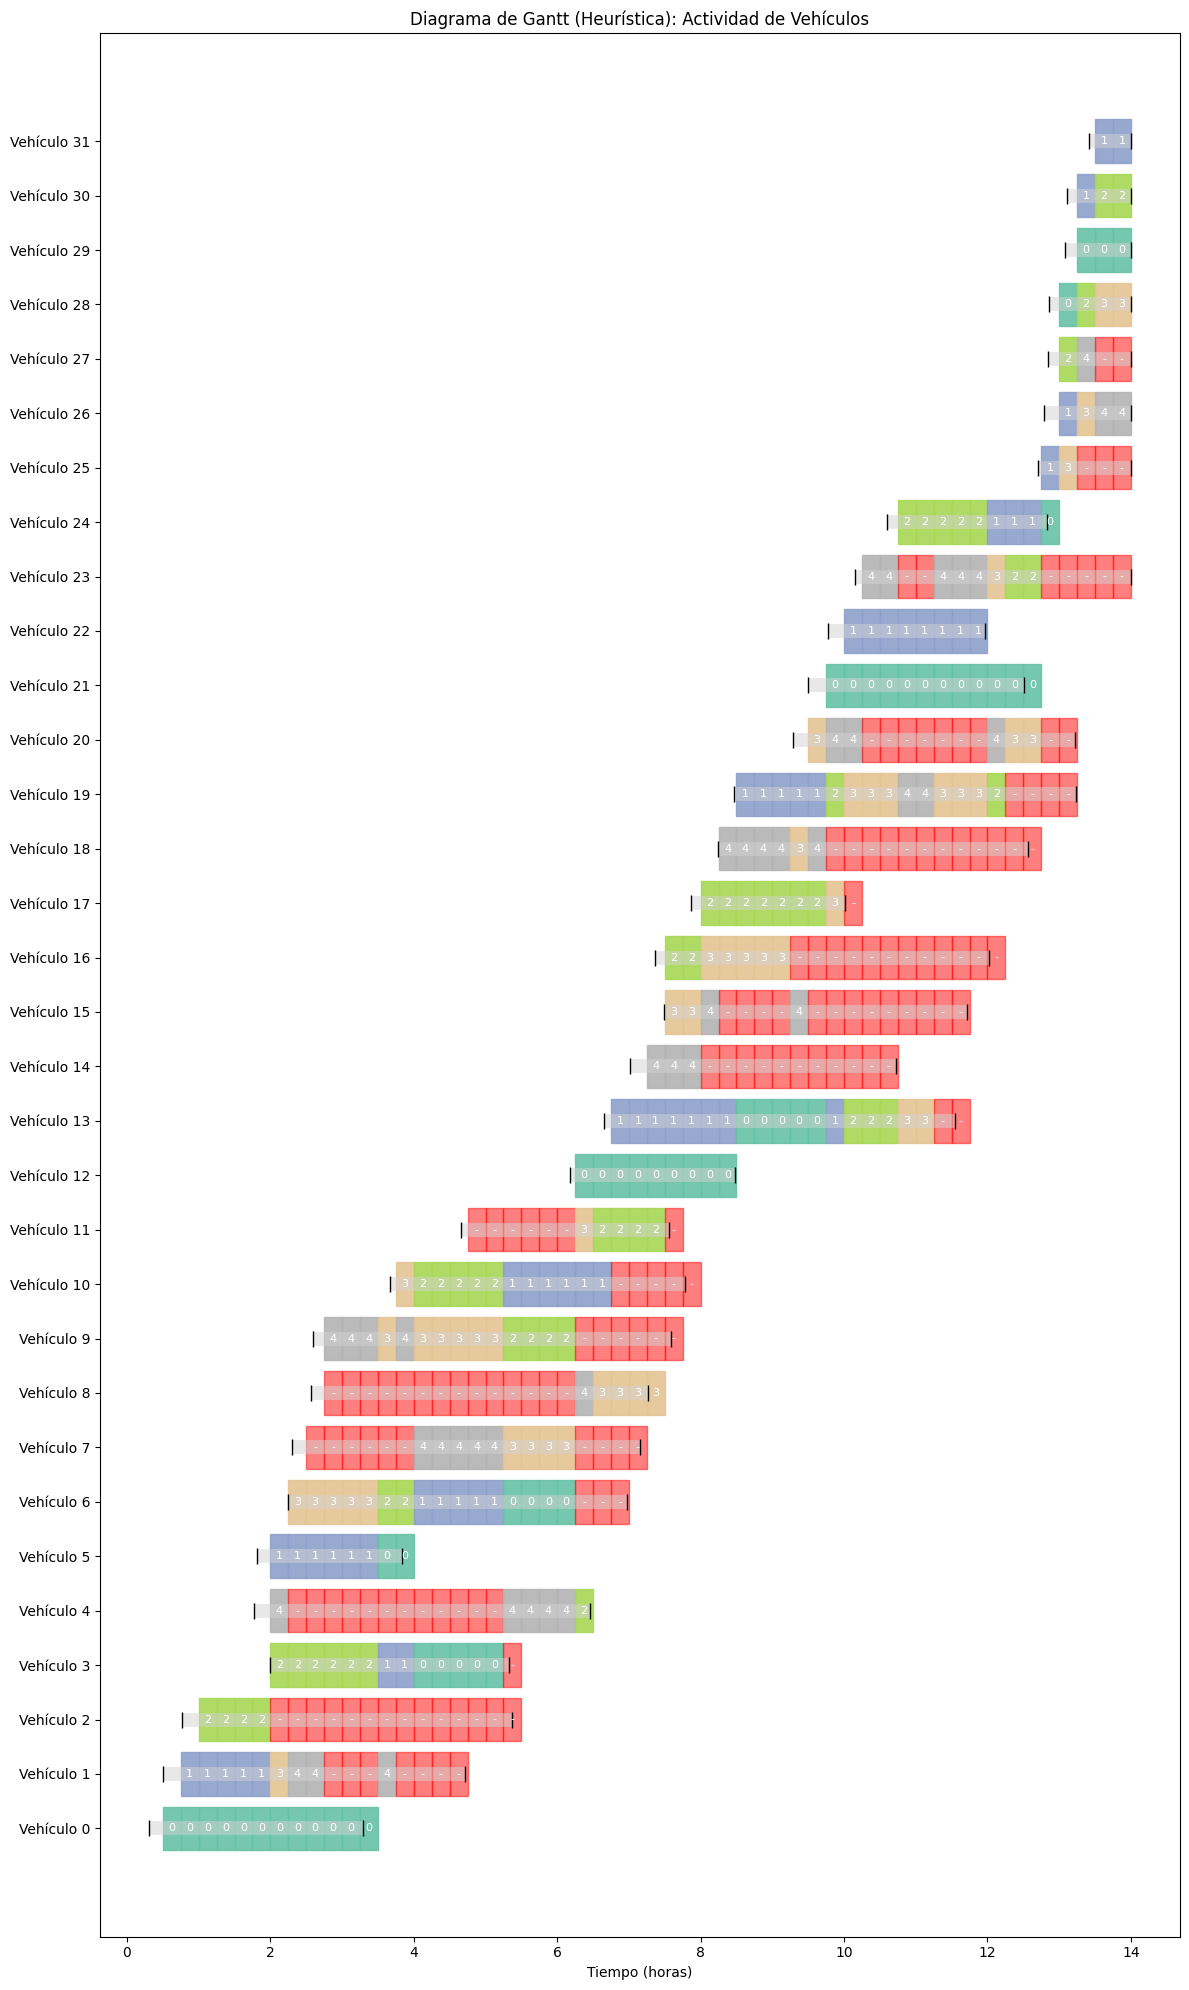

Procesando instancia test_system_2.json...
Set parameter TimeLimit to value 3600
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3301 rows, 7688 columns and 44955 nonzeros
Model fingerprint: 0xd3b527e3
Model has 99 quadratic objective terms
Variable types: 148 continuous, 7540 integer (7540 binary)
Coefficient statistics:
  Matrix range     [5e-04, 2e+01]
  Objective range  [2e+01, 3e+02]
  QObjective range [1e-02, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 1e+02]
Found heuristic solution: objective -1.47000e+12
Presolve removed 1973 rows and 688 columns
Presolve time: 0.06s
Presolved: 1328 rows, 7000 columns, 27595 nonzeros
Presolved model has 99 quadratic objective terms
Found heuristic solution: objective -0.

In [43]:
def compute_gap(model_metrics, heuristic_metrics):
    """
    Calcula el GAP para cada métrica, definido como (modelo - heurística) / modelo.
    
    Parámetros:
        model_metrics (dict): Métricas del modelo exacto.
        heuristic_metrics (dict): Métricas de la heurística.
        
    Retorna:
        dict: GAP para cada métrica.
    """
    gap = {}
    keys = ["objective_value", "avg_energy_delivered_kWh", "avg_service_level",
            "avg_delay_hours", "avg_charger_utilization_percent", "transformer_utilization_kW"]
    for key in keys:
        m_val = model_metrics.get(key)
        h_val = heuristic_metrics.get(key)
        if m_val is not None and h_val is not None:
            if abs(m_val) > 1e-6:
                gap[key] = (m_val - h_val) / m_val
            else:
                gap[key] = 0.0
    return gap

def vehicle_metrics_df_model(model, data):
    """
    Genera un DataFrame con las métricas a nivel de vehículo para el modelo exacto.
    
    Parámetros:
        model (gurobipy.Model): Modelo exacto resuelto.
        data (tuple): Conjuntos de datos y parámetros usados en el modelo.
    
    Retorna:
        pandas.DataFrame: Métricas por vehículo.
    """
    T, price, Delta_t, I, T_i, arr_time, dep_time, req_energy, _, _, _, _ = data
    rows = []
    for i in I:
        E_val = model.getVarByName(f"E_{i}").X
        D_val = model.getVarByName(f"D_{i}").X
        sl = E_val / req_energy[i] if req_energy[i] > 0 else 0
        rows.append({
            "Vehículo": i,
            "Energía Entregada (kWh)": E_val,
            "Retraso (horas)": D_val,
            "Nivel de Servicio (%)": sl * 100
        })
    return pd.DataFrame(rows)

def charger_metrics_df_model(model, data):
    """
    Genera un DataFrame con las métricas a nivel de cargador para el modelo exacto.
    
    Parámetros:
        model (gurobipy.Model): Modelo exacto resuelto.
        data (tuple): Conjuntos de datos y parámetros usados en el modelo.
    
    Retorna:
        pandas.DataFrame: Métricas por cargador.
    """
    T, price, Delta_t, I, T_i, _, _, _, C_set, P_charger, _, transformer_limit = data
    total_slots = len(T)
    rows = []
    charger_active = {c: 0 for c in C_set}
    for t in range(total_slots):
        for c in C_set:
            for i in I:
                if t in T_i[i]:
                    try:
                        if model.getVarByName(f"x_{i}_{t}_{c}").X > 0.5:
                            charger_active[c] += 1
                            break
                    except:
                        pass
    for c in C_set:
        util = charger_active[c] / total_slots * 100
        rows.append({
            "Cargador": c,
            "Períodos Activos": charger_active[c],
            "Utilización (%)": util
        })
    return pd.DataFrame(rows)

def vehicle_metrics_df_heuristic(sol):
    """
    Genera un DataFrame con las métricas a nivel de vehículo para la solución heurística.
    
    Parámetros:
        sol (dict): Solución heurística.
    
    Retorna:
        pandas.DataFrame: Métricas por vehículo.
    """
    rows = []
    for i, E_val in sol["E"].items():
        D_val = sol["D"][i]
        sl = sol["service_levels"][i]
        rows.append({
            "Vehículo": i,
            "Energía Entregada (kWh)": E_val,
            "Retraso (horas)": D_val,
            "Nivel de Servicio (%)": sl * 100
        })
    return pd.DataFrame(rows)

def charger_metrics_df_heuristic(sol, T, C_set, num_periods):
    """
    Genera un DataFrame con las métricas a nivel de cargador para la solución heurística.
    
    Parámetros:
        sol (dict): Solución heurística.
        T (list): Lista de tiempos.
        C_set (list): Conjunto de cargadores.
        num_periods (int): Número total de periodos.
    
    Retorna:
        pandas.DataFrame: Métricas por cargador.
    """
    charger_active = {c: 0 for c in C_set}
    for t in range(num_periods):
        for c in C_set:
            for i, sched in sol["vehicle_schedule"].items():
                if any(t_ass == t and c_ass == c for (t_ass, c_ass) in sched):
                    charger_active[c] += 1
                    break
    rows = []
    for c in C_set:
        util = charger_active[c] / num_periods * 100
        rows.append({
            "Cargador": c,
            "Períodos Activos": charger_active[c],
            "Utilización (%)": util
        })
    return pd.DataFrame(rows)

def main():
    """
    Función principal que integra la ejecución del modelo exacto y la heurística constructiva,
    compara las métricas obtenidas, calcula el GAP entre ambas soluciones, genera gráficos para la
    instancia seleccionada ("test_system_1.json") y guarda los resultados en archivos CSV.

    La función itera sobre los archivos de instancia disponibles, ejecuta el modelo MILP con Gurobi y la heurística,
    extrae las métricas a nivel global, por vehículo y por cargador, y finalmente guarda los resultados para análisis.
    """
    results = {}
    global_results = []
    vehicle_metrics_model_all = []
    charger_metrics_model_all = []
    vehicle_metrics_heur_all = []
    charger_metrics_heur_all = []

    # Se define la lista de archivos de instancia
    instance_files = [f"test_system_{i}.json" for i in range(1, 11)]
    
    for filename in instance_files:
        if not os.path.exists(filename):
            print(f"Archivo {filename} no encontrado. Saltando.")
            continue
        try:
            instance = read_instance(filename)
        except Exception as e:
            print(f"Error leyendo {filename}: {e}")
            continue
        
        print(f"Procesando instancia {filename}...")

        # Ejecuta el modelo exacto (MILP)
        model, data = build_model(instance)
        t_start_model = time.time()
        optimize_instance(model)
        elapsed_model = time.time() - t_start_model
        model_metrics = extract_metrics(model, data)
        model_metrics["elapsed_time_sec"] = elapsed_model

        df_vehicle_model = vehicle_metrics_df_model(model, data)
        df_charger_model = charger_metrics_df_model(model, data)

        # Ejecuta la heurística constructiva
        t_start_heur = time.time()
        heuristic_sol = heuristic_schedule(instance)
        elapsed_heur = time.time() - t_start_heur
        heuristic_metrics = heuristic_sol["heuristic_metrics"]
        heuristic_metrics["elapsed_time_sec"] = elapsed_heur

        df_vehicle_heur = vehicle_metrics_df_heuristic(heuristic_sol)
        df_charger_heur = charger_metrics_df_heuristic(heuristic_sol, data[0], data[8], len(data[0]))

        # Calcula el GAP entre las métricas del modelo exacto y la heurística
        gap_metrics = compute_gap(model_metrics, heuristic_metrics)

        instance_result = {
            "instance": filename,
            "model_metrics": model_metrics,
            "heuristic_metrics": heuristic_metrics,
            "gap_metrics": gap_metrics
        }
        results[filename] = instance_result
        global_results.append({
            "instance": filename,
            "Model_Obj": model_metrics["objective_value"],
            "Heuristic_Obj": heuristic_metrics["objective_value"],
            "Gap_Obj": gap_metrics["objective_value"],
            "Model_AvgDelay": model_metrics["avg_delay_hours"],
            "Heuristic_AvgDelay": heuristic_metrics["avg_delay_hours"],
            "Gap_Delay": gap_metrics["avg_delay_hours"],
            "Model_AvgService": model_metrics["avg_service_level"],
            "Heuristic_AvgService": heuristic_metrics["avg_service_level"],
            "Gap_Service": gap_metrics["avg_service_level"]
        })

        print(f"Resultados para {filename}:")
        print("Métricas Modelo:")
        for key, val in model_metrics.items():
            print(f"  {key}: {val}")
        print("Métricas Heurística:")
        for key, val in heuristic_metrics.items():
            print(f"  {key}: {val}")
        print("GAP (modelo - heurística) / modelo:")
        for key, val in gap_metrics.items():
            print(f"  {key}: {val}")
        print("-" * 50)

        # Guardar métricas por vehículo y cargador en DataFrames
        df_vehicle_model["instance"] = filename
        df_charger_model["instance"] = filename
        df_vehicle_heur["instance"] = filename
        df_charger_heur["instance"] = filename
        
        vehicle_metrics_model_all.append(df_vehicle_model)
        charger_metrics_model_all.append(df_charger_model)
        vehicle_metrics_heur_all.append(df_vehicle_heur)
        charger_metrics_heur_all.append(df_charger_heur)

        # Para la instancia seleccionada ("test_system_1.json"), se generan gráficos para visualización
        if filename == "test_system_1.json":
            print(f"Generando gráficos para {filename} (Modelo MILP)...")
            plot_gantt_chart(model, data)
            plot_transformer_usage_price(model, data)
            plot_vehicle_activity_gantt(model, data)
            print(f"Generando gráficos para {filename} (Heurística)...")
            plot_heuristic_gantt_chargers(heuristic_sol, data[0], data[2], data[8], data[9])
            plot_heuristic_transformer_usage(heuristic_sol, data[0], data[1], data[2], data[3], data[4], data[9], data[8], data[11])
            plot_heuristic_vehicle_activity(heuristic_sol, data[0], data[2], data[3], data[4], data[5], data[6], data[8])
    
    # Guardar resultados globales en un archivo CSV
    df_global = pd.DataFrame(global_results)
    df_global.to_csv("global_comparison_metrics.csv", index=False)
    print("Métricas globales guardadas en 'global_comparison_metrics.csv'.")

    if vehicle_metrics_model_all:
        df_vehicle_model_all = pd.concat(vehicle_metrics_model_all, ignore_index=True)
        df_charger_model_all = pd.concat(charger_metrics_model_all, ignore_index=True)
        df_vehicle_model_all.to_csv("vehicle_metrics_model.csv", index=False)
        df_charger_model_all.to_csv("charger_metrics_model.csv", index=False)
        print("Métricas por vehículo y cargador (modelo) guardadas.")
    if vehicle_metrics_heur_all:
        df_vehicle_heur_all = pd.concat(vehicle_metrics_heur_all, ignore_index=True)
        df_charger_heur_all = pd.concat(charger_metrics_heur_all, ignore_index=True)
        df_vehicle_heur_all.to_csv("vehicle_metrics_heuristic.csv", index=False)
        df_charger_heur_all.to_csv("charger_metrics_heuristic.csv", index=False)
        print("Métricas por vehículo y cargador (heurística) guardadas.")

if __name__ == "__main__":
    main()
